## surprise (A python scikit for recommender systems) 설치하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
cd /content/drive/MyDrive/sec2_recommendation_system

/content/drive/MyDrive/sec2_recommendation_system


In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3156239 sha256=244e0a20d3adeb4e05483c80d9a4d4f9ac1306f511b23117f703dbfb038950bb
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## 사용할 패키지 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import random

from IPython.display import display
from tqdm import tqdm
from collections import defaultdict

seed = 0
np.random.seed(seed)
random.seed(seed)
warnings.filterwarnings(action='ignore')

# **파일용량 초과로 원본 파일을 깃허브로 공유하지 못하였습니다.**
# **이 부분은 코드 실행 건너뛰고, 아래 코드 실행 문구부터 다시 코드 실행 부탁드립니다.**
**("영화 ID - 제목 데이터 불러오기" 파트부터 실행하시면 됩니다.)**

## 실습 데이터 불러오기


> 넷플릭스가 영화에 대한 유저의 평점을 예측하는 최적의 알고리즘을 만들기 위해 Netflix Prize open competition을 개최


> 사용자 id (Cust_Id) 와 해당 사용자가 영화에 남긴 평점 (Rating, 1~5)으로 이루어져 있음

In [ ]:
# Skip date
df = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df['Rating'] = df['Rating'].astype(float)

print('shape: {}\n'.format(df.shape))
print('-Dataset examples-')
df.iloc[::5000000, :]

shape: (24058263, 2)

-Dataset examples-


,Cust_Id,Rating
0,1:,NaN
5000000,2560324,4.0
10000000,2271935,2.0
15000000,1921803,2.0
20000000,1933327,3.0


## 데이터 형태


> "Cust_Id", "Rating" 두 칼럼을 가짐

> 각 행은 해당 사용자가 영화에 남긴 평점을 나타냄

> Rating 칼럼에 'NaN' 을 갖는 행이 있는데, 이 행은 영화 ID 를 나타내며 이 행 이후의 평점은 그 영화에 대한 평점임을 나타냄




In [ ]:
display(df.loc[0:2, :])
display(df.loc[548:551, :])
display(df.loc[694:696, :])

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0


,Cust_Id,Rating
548,2:,NaN
549,2059652,4.0
550,1666394,3.0
551,1759415,4.0


,Cust_Id,Rating
694,3:,NaN
695,1025579,4.0
696,712664,5.0


## 영화 ID (Movie_Id) 칼럼 추가하기

In [ ]:
ratings = df.Rating.values
movie_id_arr = np.cumsum(np.isnan(ratings))
df['Movie_Id'] = movie_id_arr
df = df.dropna(axis=0)
df.Cust_Id = df.Cust_Id.astype(int)
df = df[['Cust_Id', 'Movie_Id', 'Rating']]

print(f'총 rating 수 : {len(df)} \n')
display(df.loc[::5000,:])

총 rating 수 : 24053764 



,Cust_Id,Movie_Id,Rating
1,1488844,1,3.0
5006,1189445,6,1.0
10008,2421394,8,3.0
15008,2342811,8,3.0
20008,1834737,8,3.0
...,...,...,...
24034492,819546,4492,2.0
24039492,2570403,4492,1.0
24044493,1042113,4493,4.0
24049496,1059719,4496,3.0


## 영화 평점 데이터의 평점 분포 확인



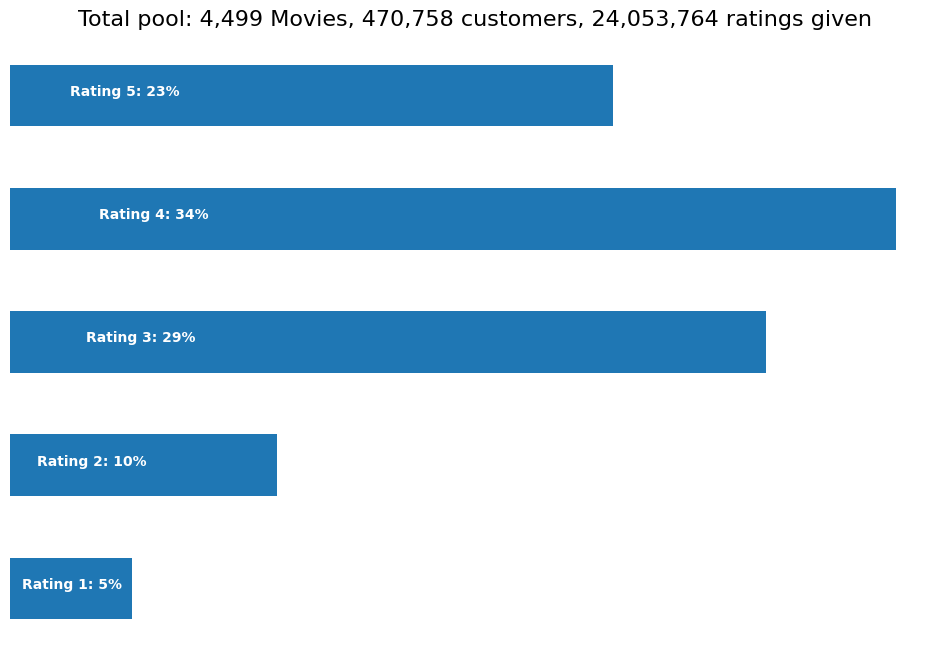

In [ ]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.Movie_Id.nunique()

# get customer count
cust_count = df['Cust_Id'].nunique()

# get rating count
rating_count = df['Cust_Id'].count()

ax = p.plot(kind = 'barh', legend = False, figsize = (12,8))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=16)
plt.axis('off')

for i in range(1, 6):
    ax.text(p.iloc[i-1][0]/10, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

# **코드 실행해주세요.**

## 영화 ID - 제목 데이터 불러오기

> 추후에 영화 제목을 사용자에게 추천하기 위해 영화 ID - 제목 매핑 데이터 불러오기

In [ ]:
df_title = pd.read_csv('movie_titles.csv', encoding = 'ISO-8859-1', on_bad_lines='skip', header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
df_title.head(10)

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


## 유저 - 아이템 행렬 구축하기

> 행렬 분해 알고리즘에 입력하기 위해 위의 유저 ID - 영화 ID - 평점 형태의 데이터프레임을 유저-아이템 평점 행렬로 바꿔야 함

> 빠른 실습 진행을 위해 500 명의 사용자 (500명의 사용자의 모든 평점 기록)를 랜덤하게 선택


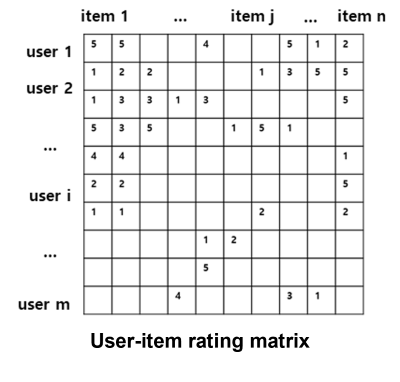

In [ ]:
from surprise import Reader, Dataset

In [ ]:
reader = Reader()

# # 빠른 실행을 위해 500명의 사용자 무작위로 선택
# n_users = 500
# all_users = df.Cust_Id.unique()
# sampled_users = np.random.choice(all_users, n_users, replace=False)
# df_sample = df.loc[df['Cust_Id'].isin(sampled_users)]

df_sample = pd.read_csv('./df_sample.csv', index_col=0)
print('- {} interactions, {} users, {} movies are selected.'.format(len(df_sample), df_sample.Cust_Id.nunique(), df_sample.Movie_Id.nunique()))
print('- only {:.2f}% of possible interactions are observed\n'.format(len(df_sample) / (df_sample.Cust_Id.nunique()*df_sample.Movie_Id.nunique()) *100))

# 관측된 데이터 (평점이 있는 사용자-영화 쌍 정보)를 사용자-아이템 평점 행렬로 변환
data = Dataset.load_from_df(df_sample[['Cust_Id', 'Movie_Id', 'Rating']], reader)
# 관측되지 않은 데이터를 저장
unobserved_data = data.build_full_trainset().build_anti_testset()


- 26124 interactions, 500 users, 2191 movies are selected.
- only 2.38% of possible interactions are observed



In [ ]:
# 리뷰어 ID, 영화 ID, 평점, 시간
data.raw_ratings[:10]

[(691460, 5, 3.0, None),
 (107840, 8, 2.0, None),
 (732873, 8, 3.0, None),
 (2621026, 8, 4.0, None),
 (497548, 8, 4.0, None),
 (230186, 8, 3.0, None),
 (46716, 8, 4.0, None),
 (2453978, 8, 2.0, None),
 (2383529, 8, 3.0, None),
 (2537651, 8, 2.0, None)]

## 모델 학습

> 2가지 행렬 분해 알고리즘 **SVD** (Singular Value Decomposition, 특이값 분해), **NMF** (Nonnegative Matrix Factorization, 비음수 행렬 분해)을 학습하여 성능을 비교


In [ ]:
from surprise import SVD, NMF, accuracy
from surprise.model_selection import cross_validate

# 행렬 분해 모델 학습을 위한 파라미터 설정
n_factors = 30
n_epochs = 100
biased = True
# lr_all = 0.005
# reg_all = 0.02

In [ ]:
# Singular value decomposition 모델 선언
algo = SVD(n_factors=n_factors, n_epochs=n_epochs, biased=biased, random_state=seed,)

In [ ]:
# 데이터셋에 대해 5개의 cross validation을 통해 성능 계산
cv_result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0469  1.0435  1.0619  1.0202  1.0264  1.0398  0.0149  
MAE (testset)     0.8155  0.8051  0.8230  0.8016  0.8005  0.8091  0.0087  
Fit time          2.73    2.58    1.66    1.73    1.89    2.12    0.45    
Test time         0.17    0.73    0.05    0.09    0.07    0.22    0.26    


In [ ]:
# 비음수 행렬 분해 (NMF) 모델 선언
algo = NMF(n_factors=n_factors, n_epochs=n_epochs, biased=biased, random_state=seed,)
# 데이터셋에 대해 5개의 cross validation을 통해 성능 계산
cv_result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5336  1.4739  1.4324  1.5968  1.5162  1.5106  0.0556  
MAE (testset)     1.1697  1.1374  1.0828  1.2387  1.1474  1.1552  0.0506  
Fit time          5.17    4.98    3.49    3.97    5.75    4.67    0.82    
Test time         0.18    0.03    0.04    0.11    0.05    0.08    0.06    


> **SVD의 RMSE, MAE 값이 낮기 때문에 SVD가 NMF보다 성능이 더 좋은 알고리즘임을 확인**  

> **SVD 알고리즘에서 최소의 오차를 갖는 모델 파라미터를 찾기 위해 GridSearch를 실행**

In [ ]:
from surprise.model_selection import GridSearchCV

# 후보 파라미터 딕셔너리 선언
param_grid = {'n_factors': [30, 50, 70, 100], 'n_epochs': [50, 100]}

# 평가지표 RMSE, MAE로 후보 파라미터의 성능을 평가하라
gs = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv = 3)
gs.fit(data)

In [ ]:
print('Best RMSE: {:.5f} | params for the best RMSE: {}'.format(gs.best_score['rmse'], gs.best_params['rmse']))
print('Best MAE: {:.5f} | params for the best MAE: {}'.format(gs.best_score['mae'], gs.best_params['mae']))

Best RMSE: 0.98766 | params for the best RMSE: {'n_factors': 100, 'n_epochs': 50}
Best MAE: 0.77472 | params for the best MAE: {'n_factors': 50, 'n_epochs': 50}


## 행렬 분해 알고리즘의 추론 과정 검증

> 행렬 분해 알고리즘이 모르는 평점을 추정하는 과정 따라가기

In [ ]:
# grid search에서 최소 오차를 기록한 모델 파라미터를 n_factors, n_epochs에 저장
n_factors, n_epochs = gs.best_params['rmse']['n_factors'], gs.best_params['rmse']['n_epochs']

# 최적 잠재요인 수 (n_factors), 훈련 epochs (n_epochs)로 SVD 모델 선언
algo = SVD(n_factors=n_factors, n_epochs=n_epochs, biased=biased, random_state=seed,)

# 관측된 기록 (유저가 영화에 대해 준 평점)을 학습 데이터셋으로 사용
trainset = data.build_full_trainset()
# 모델 학습
algo.fit(trainset)
# 관측되지 않은 데이터 (평점이 없는 경우)에 대해 평점 예측
unobserved_pred = algo.test(unobserved_data)

In [ ]:
user_dict = {i:trainset.to_raw_uid(i) for i in trainset.all_users()} # 인코딩된 사용자 id: 원래 사용자 id
item_dict = {i:trainset.to_raw_iid(i) for i in trainset.all_items()} # 인코딩된 영화 id: 원래 영화 id

print('(encoded id, raw id):', list(user_dict.items())[:5])
print('(encoded id, raw id)    :', list(item_dict.items())[:5])

(encoded id, raw id): [(0, 691460), (1, 107840), (2, 732873), (3, 2621026), (4, 497548)]
(encoded id, raw id)    : [(0, 5), (1, 8), (2, 15), (3, 16), (4, 17)]


In [ ]:
uid = 0
iid = 0

pu = algo.pu[uid]
qi = algo.qi[iid]
bu = algo.bu[uid]
bi = algo.bi[iid]

print('사용자 잠재 벡터의 형태 (p_u) = (n_user, n_latent)={}: \nEx) {}번 사용자의 잠재 벡터 (raw id: {})\n{}\n'.format(algo.pu.shape, uid, user_dict[uid], pu))
print('아이템 (영화) 잠재 벡터의 형태 (q_i) = (n_item, n_latent)={}: \nEx) {}번 아이템 (영화) 잠재 벡터 (raw id: {})\n{}\n'.format(algo.qi.shape, iid, item_dict[iid], qi))
print('사용자 편향의 형태 (b_u) = (n_user, )={}: \nEx) {}번 사용자의 편향 (실제 id: {}): {}\n'.format(algo.bu.shape, uid, user_dict[uid], bu))
print('아이템 편향의 형태 (b_i) = (n_item, )={}: \nEx) {}번 아이템의 편향 (실제 id: {}): {}'.format(algo.bi.shape, iid, item_dict[iid], bi))

사용자 잠재 벡터의 형태 (p_u) = (n_user, n_latent)=(500, 100): 
Ex) 0번 사용자의 잠재 벡터 (raw id: 691460)
[ 0.13830289  0.05636957  0.1678234   0.22489489  0.17572696 -0.10964286
  0.02453429  0.12441161  0.07778915  0.07602791 -0.01516403  0.14128562
  0.16495229 -0.02343384  0.11998225  0.10818942  0.21528451 -0.02086977
  0.13056129 -0.25326266 -0.36657045  0.04420664  0.13068961 -0.16849848
  0.34072512 -0.11968747 -0.1486484   0.02422448  0.16192484  0.23006108
  0.00360577  0.11352572 -0.10525858 -0.15672678  0.04832429 -0.05268478
  0.17297172  0.11985125 -0.0808105  -0.04394276 -0.07670131 -0.2077506
 -0.07494322  0.23375697 -0.10586039 -0.02794113 -0.17162864  0.10850498
 -0.2869008  -0.08531325 -0.02406449  0.06326335 -0.01095554 -0.24510427
  0.03467818 -0.01412783  0.03990893  0.0933595  -0.15981176  0.06310463
 -0.02342863  0.01498881 -0.01404957 -0.16769967  0.03056766 -0.09733002
 -0.23921113  0.11114167 -0.19306694 -0.03543087  0.34069093 -0.02340538
  0.21010548 -0.11656842 -0.1233233 

In [ ]:
# prediction by SVD.predict method
algo.predict(user_dict[uid], item_dict[iid])

Prediction(uid=691460, iid=5, r_ui=None, est=3.4788938333954476, details={'was_impossible': False})

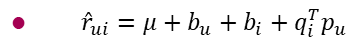

In [ ]:
# manual calculation
trainset.global_mean + bu + bi + np.dot(pu, qi)

3.4788938333954476

## 상위 N개 영화 추천

> 사용자가 평점을 매기지 않은 영화 중 사용자가 좋아할 것 같은 영화 N개 추천 (예측 평점 상위 N개의 영화)


In [ ]:
def get_top_n(predictions, user_dict, user, n=10):
    """
    user에게 user가 보지 않은 영화 중 평점 상위 n개의 추천 영화 목록을 반환
    [(raw item id, rating estimation), ...] of size n.
    """
    # First map the predictions to each user.
    top_n = []
    for uid, iid, true_r, est, _ in predictions:
        if user_dict[user]==uid:
            top_n.append((iid, est))
    top_n.sort(key=lambda x: x[1], reverse=True)
    top_n = top_n[:n]

    print('Top-{} recommendations for user {} (raw id: {})'.format(n, user, user_dict[user]))
    for iid, est in top_n:
        print('예상 평점: {:.5f} | 영화 ID:{:>5} | 제목: {}'.format(est, iid, df_title.loc[iid].Name))

    return top_n

In [ ]:
top_n = get_top_n(unobserved_pred, user_dict, user=0, n=10)

Top-10 recommendations for user 0 (raw id: 691460)
예상 평점: 5.00000 | 영화 ID:  241 | 제목: North by Northwest
예상 평점: 5.00000 | 영화 ID:  646 | 제목: Matewan
예상 평점: 5.00000 | 영화 ID:  886 | 제목: Ray
예상 평점: 5.00000 | 영화 ID: 1795 | 제목: MASH: Season 7
예상 평점: 5.00000 | 영화 ID: 1890 | 제목: Regarding Henry
예상 평점: 5.00000 | 영화 ID: 1905 | 제목: Pirates of the Caribbean: The Curse of the Black Pearl
예상 평점: 5.00000 | 영화 ID: 2532 | 제목: Futurama: Vol. 1
예상 평점: 5.00000 | 영화 ID: 2803 | 제목: Pride and Prejudice
예상 평점: 5.00000 | 영화 ID: 3446 | 제목: Spirited Away
예상 평점: 5.00000 | 영화 ID: 3605 | 제목: The Wizard of Oz: Collector's Edition


In [ ]:
top_n = get_top_n(unobserved_pred, user_dict, user=40, n=10)

Top-10 recommendations for user 40 (raw id: 1038731)
예상 평점: 5.00000 | 영화 ID:  223 | 제목: Chappelle's Show: Season 1
예상 평점: 5.00000 | 영화 ID:  422 | 제목: The Unsinkable Molly Brown
예상 평점: 5.00000 | 영화 ID:  443 | 제목: Rabbit-Proof Fence
예상 평점: 5.00000 | 영화 ID:  471 | 제목: City Lights
예상 평점: 5.00000 | 영화 ID:  646 | 제목: Matewan
예상 평점: 5.00000 | 영화 ID:  752 | 제목: Star Trek: The Next Generation: Season 7
예상 평점: 5.00000 | 영화 ID:  872 | 제목: Seven Samurai
예상 평점: 5.00000 | 영화 ID:  886 | 제목: Ray
예상 평점: 5.00000 | 영화 ID:  908 | 제목: Sense and Sensibility
예상 평점: 5.00000 | 영화 ID: 1220 | 제목: Man on Fire


## 유사한 선호를 갖는 영화 목록 추천

> 입력한 영화와 유사한 잠재 표현을 갖는 (사용자의 선호 패턴이 비슷한) N개의 영화 목록 출력

> 영화의 잠재 벡터 간 유사도 값이 가장 높은 N개의 영화 목록 추천


In [ ]:
def similar_movies(algo, item_dict, item, n):

    query_repr = algo.qi[item] # 입력 아이템의 잠재 표현
    key_repr = algo.qi # 전체 아이템의 잠재 표현

    sim = np.dot(query_repr, key_repr.T)/(np.sqrt(sum(query_repr**2))*np.sqrt(np.sum(key_repr**2, axis=1))) # 입력 아이템과 다른 전체 아이템과의 유사도

    # the n most similar movies by cosine similarities of latent vectors
    # 입력한 영화와 사용자 선호에 대한 유사도가 가장 높은 n개 영화 id
    remove_movie_idx = [item]
    while True:
        enc_most_similar_movies = list(np.argsort(sim)[::-1][:n+1])
        query_idx = np.argwhere(enc_most_similar_movies==item)
        enc_most_similar_movies = [idx for idx in enc_most_similar_movies if idx not in remove_movie_idx]
        raw_most_similar_movies = [item_dict[i] for i in enc_most_similar_movies]

        # 에러 발생 예외 처리 코드
        try:
            df_title.loc[raw_most_similar_movies]
        except:
            all_movie_ids = list(df_title.index)
            err_movie_ids = list(set(raw_most_similar_movies).difference(all_movie_ids))   # all_movie_ids 안에 있는지 확인 (영화id-영화제목 데이터셋에서 id가 겹치지 않는 데이터가 있을 수도 있음)
            remove_movie_idx += [trainset.to_inner_iid(idx) for idx in err_movie_ids]
            n += len(err_movie_ids)
        else:
            break

    print(f'입력 영화 : {df_title.loc[item_dict[item]].Name}\n')

    return df_title.loc[raw_most_similar_movies]

In [ ]:
similar_movies(algo, item_dict, item=10, n=10)

2191
입력 영화 : Never Die Alone



,Year,Name
Movie_Id,,
1715,2005.0,Confessions of an American Bride
516,2001.0,Monsoon Wedding
3405,2002.0,The Dead Zone: Season 2
3013,1973.0,Westworld
2490,1999.0,Jackson Pollock: Love and Death on Long Island
3626,2002.0,25th Hour
2550,1997.0,Astronomy Adventure: Learning Astronomy Histor...
2283,1988.0,The Couch Trip
4463,2000.0,Escaflowne: The Movie


In [ ]:
similar_movies(algo, item_dict, item=20, n=10)

2191
입력 영화 : Rudolph the Red-Nosed Reindeer



,Year,Name
Movie_Id,,
2002,2002.0,Nijinsky
3106,1990.0,Ghost
4474,1998.0,Black Mask
1050,1982.0,Annie: Special Anniversary Edition
3887,1972.0,Aguirre: The Wrath of God
1532,1992.0,Mo' Money
2873,1972.0,Joe Kidd
280,1998.0,Sarah Brightman: In Concert
1800,2002.0,An Evening With Kevin Smith


## t-SNE 시각화 방법론을 활용하여 영화 잠재 벡터 시각화하기


In [ ]:
from sklearn.manifold import TSNE

# 영화 잠재 벡터 (고차원)를 시각화하기 위해 2차원으로 변환하는 모형
tsne = TSNE(n_components=2, perplexity=10, n_iter=1000, verbose=3, random_state=seed)
movie_embedding = tsne.fit_transform(algo.qi) # 2차원의 영화 백터

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2191 samples in 0.001s...
[t-SNE] Computed neighbors for 2191 samples in 0.244s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2191
[t-SNE] Computed conditional probabilities for sample 2000 / 2191
[t-SNE] Computed conditional probabilities for sample 2191 / 2191
[t-SNE] Mean sigma: 0.238039
[t-SNE] Computed conditional probabilities in 0.058s
[t-SNE] Iteration 50: error = 89.0809784, gradient norm = 0.0890874 (50 iterations in 2.775s)
[t-SNE] Iteration 100: error = 89.4615631, gradient norm = 0.1166100 (50 iterations in 1.210s)
[t-SNE] Iteration 150: error = 89.3504791, gradient norm = 0.1487564 (50 iterations in 1.220s)
[t-SNE] Iteration 200: error = 89.2683411, gradient norm = 0.1591685 (50 iterations in 0.999s)
[t-SNE] Iteration 250: error = 89.3330078, gradient norm = 0.0848735 (50 iterations in 1.868s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.333008
[t-SNE] Iteration 300: erro

In [ ]:
projection = pd.DataFrame(columns=['x', 'y'], data=movie_embedding)

movie_names = []
for key, val in item_dict.items():
    try:
        movie_names.append(df_title.loc[val, 'Name'])
    except:
        movie_names.append(np.NaN)

encoded_movie_ids = list(item_dict.keys())
projection['Title'] = movie_names
projection['Movie_Id_Encoded'] = encoded_movie_ids
projection = projection.dropna()
projection

,x,y,Title,Movie_Id_Encoded
0,-28.925129,-32.924351,The Rise and Fall of ECW,0
1,28.067062,9.179423,What the #$*! Do We Know!?,1
2,-17.942051,31.016630,Neil Diamond: Greatest Hits Live,2
3,-7.596366,1.255119,Screamers,3
4,14.830997,-42.754776,7 Seconds,4
...,...,...,...,...
2186,14.271781,-53.572861,Club Dread,2186
2187,27.748354,-24.652058,Ju-on: The Grudge,2187
2188,-1.686711,43.304798,Cartoon Crazys: Vol. 1,2188
2189,-10.687143,-29.630405,Clifford: Happy Birthday Clifford / Puppy Love,2189


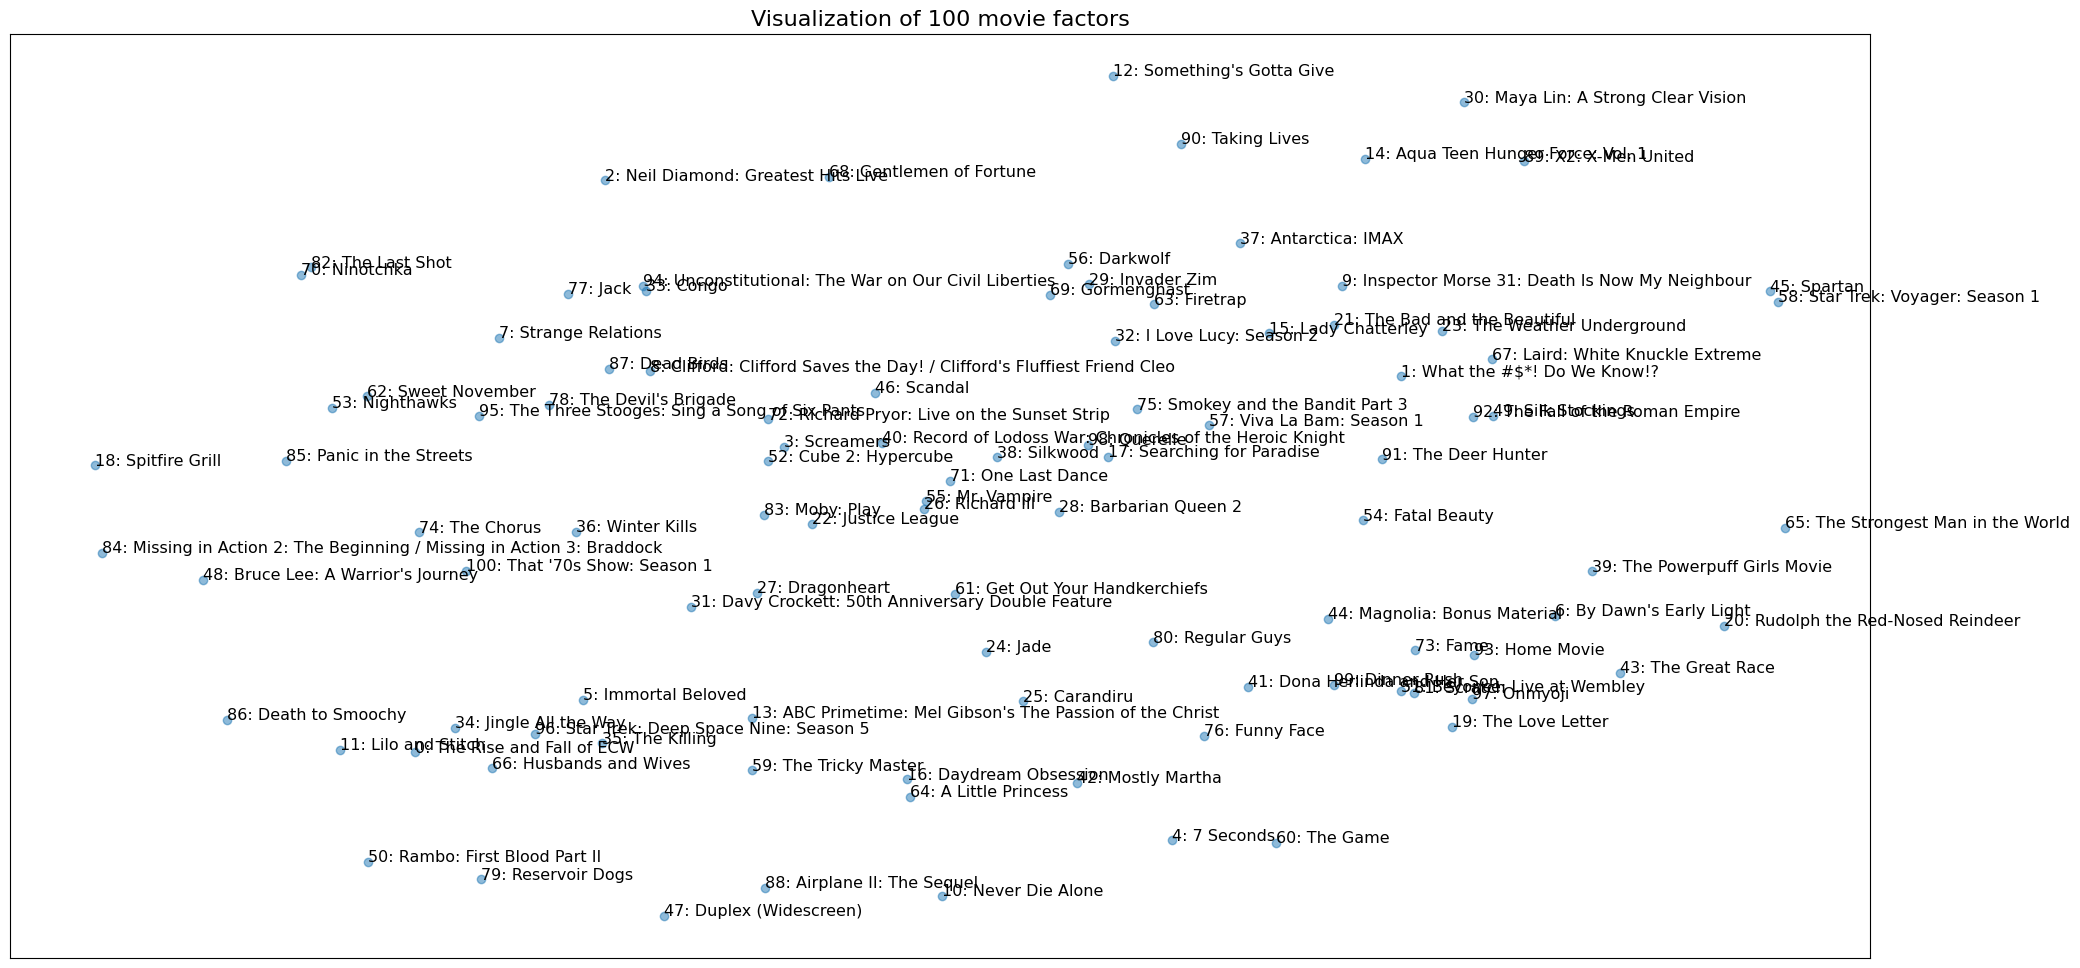

In [ ]:
n_samples = 100
projection_plot = projection.loc[:n_samples]
fig, ax = plt.subplots(figsize=(24, 12))
ax.scatter(projection_plot.x.values, projection_plot.y.values, alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_title(f'Visualization of {n_samples} movie factors', size=16)
for i, (mid, txt) in enumerate(zip(projection_plot.Movie_Id_Encoded, projection_plot.Title)):
    ax.annotate('{}: {}'.format(mid, txt), (projection_plot.x.values[i], projection_plot.y.values[i]), fontsize=11.5)